<a href="https://colab.research.google.com/github/asab77/MAT-422/blob/main/Research_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Confusion Matrix:
 [[75  1]
 [ 2 72]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        76
           1       0.99      0.97      0.98        74

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

Accuracy: 0.98


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


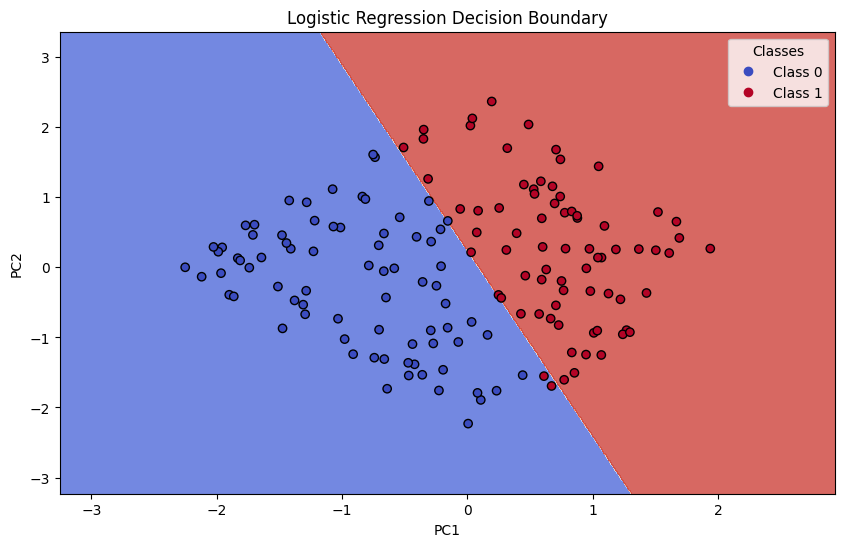

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Step 1: Generate synthetic data
np.random.seed(42)

# Generate continuous variables
X1 = np.random.rand(500, 1) * 10  # Continuous feature 1
X2 = np.random.rand(500, 1) * 20  # Continuous feature 2

# Generate discrete variables
categories = np.random.choice(['A', 'B', 'C'], size=(500, 1))

# Binary target variable
y = (X1 + X2 > 15).astype(int).ravel()  # Target: 1 if sum > 15, else 0

# Combine into a DataFrame
data = pd.DataFrame(
    np.hstack((X1, X2, categories, y.reshape(-1, 1))),
    columns=["X1", "X2", "Category", "Target"]
)

# Step 2: Preprocessing
# Normalize continuous variables
scaler = StandardScaler()
data[["X1", "X2"]] = scaler.fit_transform(data[["X1", "X2"]])

# Encode categorical variables
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output=False for compatibility with PCA
encoded_categories = encoder.fit_transform(data[["Category"]])
encoded_category_cols = encoder.get_feature_names_out(["Category"])

# Combine encoded categories with normalized data
preprocessed_data = pd.DataFrame(
    np.hstack((data[["X1", "X2"]], encoded_categories)),
    columns=["X1", "X2"] + list(encoded_category_cols)
)
preprocessed_data["Target"] = data["Target"].astype(int)

# Step 3: Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components
principal_components = pca.fit_transform(preprocessed_data.drop("Target", axis=1))

# Create PCA DataFrame
pca_df = pd.DataFrame(principal_components, columns=["PC1", "PC2"])
pca_df["Target"] = preprocessed_data["Target"].astype(int)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    pca_df[["PC1", "PC2"]],
    pca_df["Target"],
    test_size=0.3,
    random_state=42
)

# Step 5: Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 6: Model Evaluation
y_pred = model.predict(X_test)

# Confusion Matrix and Classification Report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Step 7: Visualization with Correction
def plot_decision_boundary(X, y, model):
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.01),
        np.arange(y_min, y_max, 0.01)
    )

    # Predict on the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    scatter = plt.scatter(
        X.iloc[:, 0],
        X.iloc[:, 1],
        c=y,
        edgecolors='k',
        cmap=plt.cm.coolwarm
    )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Logistic Regression Decision Boundary")
    plt.legend(
        handles=scatter.legend_elements()[0],
        labels=["Class 0", "Class 1"],
        title="Classes"
    )
    plt.show()

# Call the plotting function
plot_decision_boundary(X_test, y_test, model)
